In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm import trange

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("customer_dataframe.csv", sep="\t", index_col=0)
df.head()

,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder
CustomerID,,,,,,,,,,,,,,
17850,1702,21,141,12,48.628571,5317.89,6.36,107.25,151.939714,8,3.960370,34,4.137478,3.186426
13047,1355,105,309,3,84.687500,3089.10,6.64,68.00,193.068750,23,3.926082,9,5.420969,3.875000
12583,4978,114,714,100,292.823529,6629.34,6.80,132.80,389.961176,3,2.140474,15,5.803909,4.087463
13748,439,24,208,8,87.800000,948.25,9.36,204.00,189.650000,0,3.996429,5,4.080050,2.321928
15100,58,1,32,16,9.666667,635.10,175.20,350.40,105.850000,3,10.950000,3,2.251629,2.251629


In [3]:
df = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [4]:
df.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4.333000e+03,4333.000000
mean,1129.535657,201.104617,3.278829e+02,3.492818
std,4692.695935,274.590135,3.953360e+02,8.997407
min,0.000000,0.000000,-3.410605e-13,0.122500
25%,157.000000,80.500000,1.550500e+02,2.160408
50%,370.000000,140.166667,2.419000e+02,2.833571
75%,971.000000,237.750000,3.715600e+02,3.711818
max,196556.000000,7824.000000,9.904875e+03,434.650000


In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [6]:
X[:2]

array([[0.00865911, 0.00621531, 0.01533989, 0.00883228],
       [0.00689371, 0.01082407, 0.0194923 , 0.00875337]])

In [7]:
# from the hierarchical clustering defined by the given linkage matrix and threshold return the cluster topology
def count_cluster_elements(data, threshold, criterion='distance'):
    count = {}
    clusters = fcluster(data, threshold, criterion)
    for c in clusters:
        count[c] = count[c]+1 if c in count else 1
    return count, clusters

In [8]:
# from flat clusters returns dictionary of dataframes representing the cluster
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

In [9]:
print(df.index)
l = [1,2,3]
print([df.index[i] for i in l])

Int64Index([17850, 13047, 12583, 13748, 15100, 15291, 14688, 17809, 15311,
            14527,
            ...
            16000, 15195, 14087, 14204, 15471, 13436, 15520, 13298, 14569,
            12713],
           dtype='int64', name='CustomerID', length=4333)
[13047, 12583, 13748]


In [10]:
methods_silhouette = {}

In [11]:
# Complete - Euclidean

Text(0.5, 1.0, 'Complete - Euclidean')

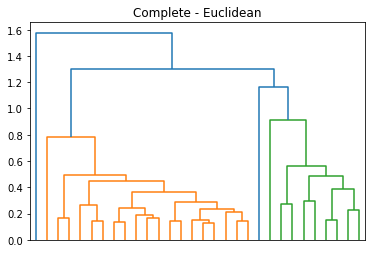

In [12]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
threshold_value = 1.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Complete - Euclidean")

In [13]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 4
[4311, 20, 1, 1]


In [14]:
score = silhouette_score(X, clusters)
methods_silhouette["complete"] = round(score, 2)
score

0.9229675769358433

In [15]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"\n*********** Cluster {cluster} - {len(cluster_df)} ***********\n")
    print(cluster_df.describe())


*********** Cluster 1 - 4311 ***********

              TProd  MeanProdOrder  MeanSaleOrder    MeanPSale
count   4311.000000    4311.000000   4.311000e+03  4311.000000
mean    1017.035259     189.215011   3.082864e+02     3.396494
std     3121.819065     186.630854   2.573804e+02     6.181522
min        0.000000       0.000000  -3.410605e-13     0.122500
25%      156.000000      80.323529   1.547067e+02     2.160673
50%      368.000000     140.000000   2.407292e+02     2.833318
75%      954.000000     235.266667   3.678648e+02     3.711157
max    76969.000000    2160.333333   2.661240e+03   295.000000

*********** Cluster 2 - 20 ***********

              TProd  MeanProdOrder  MeanSaleOrder  MeanPSale
count     20.000000      20.000000      20.000000  20.000000
mean   15661.100000    2650.449559    3901.219784   2.747467
std    23975.809471    1619.823533    1276.855822   1.636387
min     1404.000000     899.500000    1152.000000   0.400000
25%     2870.000000    1398.100000    3185.4

In [16]:
# Single - Euclidean

Text(0.5, 1.0, 'Single - Euclidean')

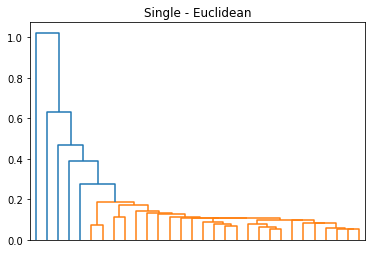

In [17]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
threshold_value = 0.2
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Single - Euclidean")

In [18]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 6
[4328, 1, 1, 1, 1, 1]


In [19]:
score = silhouette_score(X, clusters)
methods_silhouette["single"] = round(score, 2)
score

0.9350227443788646

In [20]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"\n*********** Cluster {cluster} - {len(cluster_df)} ***********\n")
    print(cluster_df.describe())


*********** Cluster 1 - 4328 ***********

              TProd  MeanProdOrder  MeanSaleOrder    MeanPSale
count   4328.000000    4328.000000   4.328000e+03  4328.000000
mean    1065.824630     198.170938   3.228479e+02     3.326944
std     3446.318084     241.975050   3.513807e+02     4.291449
min        0.000000       0.000000  -3.410605e-13     0.122500
25%      157.000000      80.500000   1.549875e+02     2.160095
50%      370.000000     140.098039   2.415750e+02     2.834058
75%      970.250000     237.500000   3.710838e+02     3.710827
max    76969.000000    4300.000000   6.212725e+03   125.000000

*********** Cluster 2 - 1 ***********

         TProd  MeanProdOrder  MeanSaleOrder  MeanPSale
count      1.0       1.000000       1.000000   1.000000
mean   76946.0    3206.083333    5151.590833   2.450323
std        NaN            NaN            NaN        NaN
min    76946.0    3206.083333    5151.590833   2.450323
25%    76946.0    3206.083333    5151.590833   2.450323
50%    76946.0

In [21]:
# Avereage - Euclidean

Text(0.5, 1.0, 'Average - Euclidean')

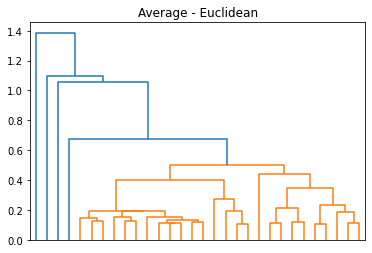

In [22]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
threshold_value = 0.5
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Average - Euclidean")

In [23]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 5
[4329, 1, 1, 1, 1]


In [24]:
score = silhouette_score(X, clusters)
methods_silhouette["average"] = round(score, 2)
score

0.9377330199523292

In [25]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"\n*********** Cluster {cluster} - {len(cluster_df)} ***********\n")
    print(cluster_df.describe())


*********** Cluster 1 - 4329 ***********

              TProd  MeanProdOrder  MeanSaleOrder    MeanPSale
count   4329.000000    4329.000000   4.329000e+03  4329.000000
mean    1083.352968     198.865767   3.239634e+02     3.326741
std     3633.788306     246.228308   3.589235e+02     4.290973
min        0.000000       0.000000  -3.410605e-13     0.122500
25%      157.000000      80.500000   1.550000e+02     2.160408
50%      370.000000     140.166667   2.416200e+02     2.833571
75%      971.000000     237.500000   3.712900e+02     3.710496
max    76969.000000    4300.000000   6.212725e+03   125.000000

*********** Cluster 2 - 1 ***********

       TProd  MeanProdOrder  MeanSaleOrder  MeanPSale
count    1.0            1.0            1.0        1.0
mean     2.0            1.0          295.0      295.0
std      NaN            NaN            NaN        NaN
min      2.0            1.0          295.0      295.0
25%      2.0            1.0          295.0      295.0
50%      2.0            1.

In [26]:
# Ward - Euclidean

Text(0.5, 1.0, 'Ward - Euclidean')

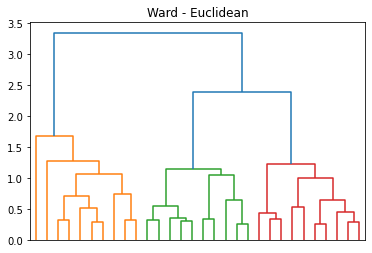

In [27]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 2.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")

In [28]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 3
[3853, 458, 22]


In [29]:
score = silhouette_score(X, clusters)
methods_silhouette["ward"] = round(score, 2)
score

0.6717132834211728

In [30]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"\n*********** Cluster {cluster} - {len(cluster_df)} ***********\n")
    print(cluster_df.describe())


*********** Cluster 1 - 22 ***********

               TProd  MeanProdOrder  MeanSaleOrder   MeanPSale
count      22.000000      22.000000      22.000000   22.000000
mean    23174.500000    2530.926810    4167.897820   22.367865
std     45064.161334    1640.016861    1765.743476   92.097676
min        61.000000      15.250000    1152.000000    0.400000
25%      2762.000000    1386.300000    3302.466607    1.192149
50%      4290.000000    2553.750000    3961.782500    2.948124
75%     15400.250000    3002.000000    4593.587500    3.998686
max    196556.000000    7824.000000    9904.875000  434.650000

*********** Cluster 2 - 3853 ***********

              TProd  MeanProdOrder  MeanSaleOrder    MeanPSale
count   3853.000000    3853.000000   3.853000e+03  3853.000000
mean     725.892551     144.078622   2.429232e+02     3.475627
std     1289.913466      91.391011   1.250883e+02     6.521402
min        0.000000       0.000000  -3.410605e-13     0.290000
25%      141.000000      75.000000

In [31]:
# ----------------------------------------------

In [32]:
methods_silhouette

{'complete': 0.92, 'single': 0.94, 'average': 0.94, 'ward': 0.67}

In [33]:
# ----------------------------------------------

In [34]:
from sklearn.cluster import AgglomerativeClustering
connectivity=None

In [35]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137829416765

Numero Cluster:  3
Cluster {0: 21, 1: 1, 2: 4311}
Silhouette Score 0.9265553584280075

Numero Cluster:  4
Cluster {0: 20, 1: 1, 2: 4311, 3: 1}
Silhouette Score 0.9229675769358433

Numero Cluster:  5
Cluster {0: 4311, 1: 1, 2: 19, 3: 1, 4: 1}
Silhouette Score 0.9187429850123897

Numero Cluster:  6
Cluster {0: 19, 1: 1, 2: 4310, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.918838578386998

Numero Cluster:  7
Cluster {0: 4310, 1: 1, 2: 14, 3: 1, 4: 1, 5: 1, 6: 5}
Silhouette Score 0.9170025727458544

Numero Cluster:  8
Cluster {0: 14, 1: 9, 2: 4301, 3: 1, 4: 1, 5: 1, 6: 5, 7: 1}
Silhouette Score 0.8136578497215359

Numero Cluster:  9
Cluster {0: 4301, 1: 3, 2: 11, 3: 9, 4: 1, 5: 1, 6: 5, 7: 1, 8: 1}
Silhouette Score 0.8137407392112684



In [36]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='single', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137829416765

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.960429757293594

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502641337838

Numero Cluster:  5
Cluster {0: 4329, 1: 1, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.9377330199523292

Numero Cluster:  6
Cluster {0: 4328, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.9350227443788646

Numero Cluster:  7
Cluster {0: 4326, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1}
Silhouette Score 0.9172175945517642

Numero Cluster:  8
Cluster {0: 4323, 1: 3, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
Silhouette Score 0.9178362855983728

Numero Cluster:  9
Cluster {0: 4321, 1: 3, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
Silhouette Score 0.9187295072770915



In [37]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137829416765

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.960429757293594

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502641337838

Numero Cluster:  5
Cluster {0: 4329, 1: 1, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.9377330199523292

Numero Cluster:  6
Cluster {0: 17, 1: 1, 2: 4312, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.9177588801279704

Numero Cluster:  7
Cluster {0: 4312, 1: 1, 2: 16, 3: 1, 4: 1, 5: 1, 6: 1}
Silhouette Score 0.914921340236521

Numero Cluster:  8
Cluster {0: 16, 1: 4304, 2: 8, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
Silhouette Score 0.9019714256894722

Numero Cluster:  9
Cluster {0: 8, 1: 5, 2: 11, 3: 4304, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
Silhouette Score 0.9020339996735516



In [38]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='ward', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4311, 1: 22}
Silhouette Score 0.9308882898037164

Numero Cluster:  3
Cluster {0: 22, 1: 458, 2: 3853}
Silhouette Score 0.6717132834211728

Numero Cluster:  4
Cluster {0: 21, 1: 458, 2: 3853, 3: 1}
Silhouette Score 0.6721012326936315

Numero Cluster:  5
Cluster {0: 458, 1: 20, 2: 3853, 3: 1, 4: 1}
Silhouette Score 0.672383777419555

Numero Cluster:  6
Cluster {0: 3853, 1: 20, 2: 96, 3: 1, 4: 1, 5: 362}
Silhouette Score 0.596162922765729

Numero Cluster:  7
Cluster {0: 20, 1: 1930, 2: 96, 3: 1, 4: 1, 5: 362, 6: 1923}
Silhouette Score 0.3893081515525163

Numero Cluster:  8
Cluster {0: 1930, 1: 6, 2: 96, 3: 14, 4: 1, 5: 362, 6: 1923, 7: 1}
Silhouette Score 0.3899324193272519

Numero Cluster:  9
Cluster {0: 96, 1: 6, 2: 10, 3: 14, 4: 1, 5: 362, 6: 1923, 7: 1, 8: 1920}
Silhouette Score 0.395690358733548

